# ENCODE Subset Peaks

Given a subset of peaks, find out which cells in ENCODE have highest/lowest fraction of reads in those peaks.

In [ ]:
library(GenomicRanges)
library(DESeq2)

In [5]:
# load encode counts matrix
cts <- read.csv("/oak/stanford/groups/akundaje/projects/atlas/counts_matrices/atlas.dnase.overlap.counts.txt",sep="\t")
rownames(cts)=paste(cts$chr,cts$start,cts$end,sep='\t')
cts$chrom = NULL
cts$start = NULL
cts$end = NULL
head(cts, 2)
dim(cts)

,ENCSR000EID,ENCSR000EIE,ENCSR000EIF,ENCSR000EIG,ENCSR000EII,ENCSR000EIL,ENCSR000EIN,ENCSR000EIV,ENCSR000EIW,ENCSR000EIY,⋯,ENCSR974TXT,ENCSR976XOY,ENCSR978QUT,ENCSR979ZJS,ENCSR986HEN,ENCSR986XLW,ENCSR988YKR,ENCSR989YIV,ENCSR990XXC,ENCSR999TSD
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1 10370 10641,28,9,17,8,49,28,7,11,20,33,⋯,2,1,0,3,2,12,0,15,3,1
chr1 10711 11232,12,9,5,9,44,39,2,7,13,27,⋯,0,1,0,1,1,2,0,9,1,0


[1] 2027128     622

In [6]:
encode_peaks_gr = GRanges(sub("\t", "-", sub("\t", ":", rownames(cts))))

In [7]:
head(encode_peaks_gr)

GRanges object with 6 ranges and 0 metadata columns:
      seqnames      ranges strand
         <Rle>   <IRanges>  <Rle>
  [1]     chr1 10370-10641      *
  [2]     chr1 10711-11232      *
  [3]     chr1 11308-11533      *
  [4]     chr1 14499-14700      *
  [5]     chr1 16142-16349      *
  [6]     chr1 25958-26158      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [ ]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

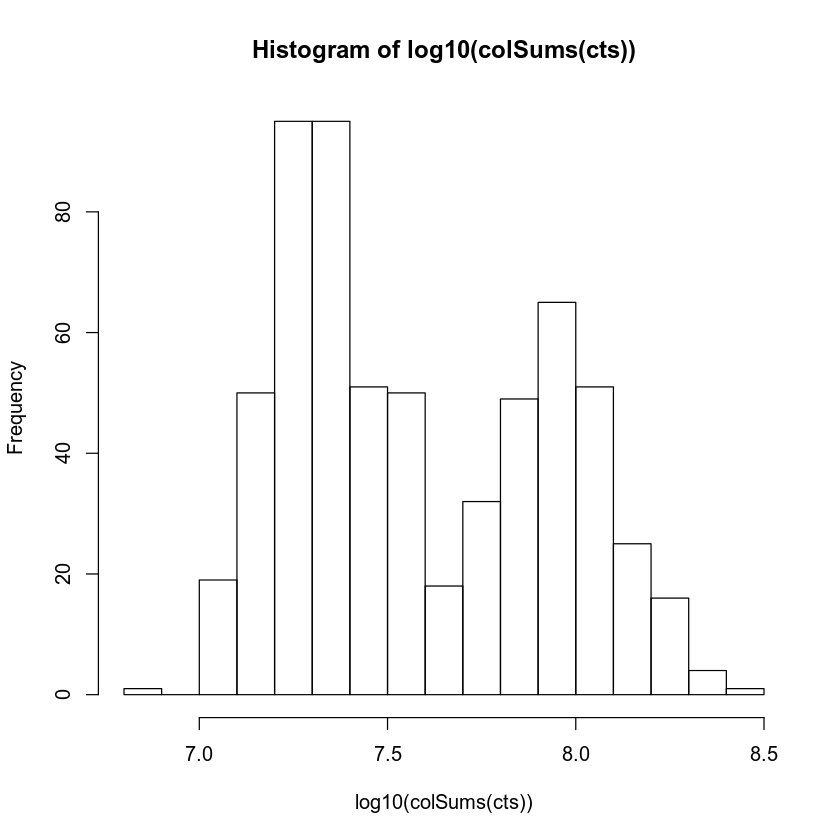

In [23]:
hist(log10(colSums(cts)))

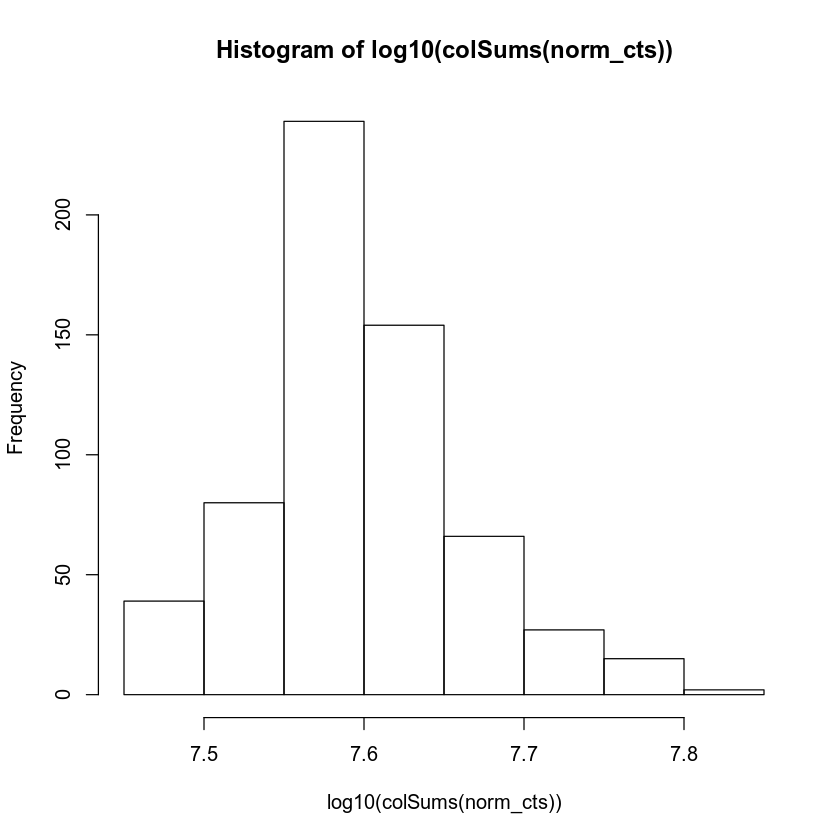

In [24]:
hist(log10(colSums(norm_cts)))

In [22]:
colnames(metadata)

[1] "Biosample.summary"   "Biosample.term.name"

In [9]:
# ENCODE metadata
metadata = read.delim("/oak/stanford/groups/akundaje/projects/atlas/dnase_experiments_metadata.tsv", 
                      sep="\t",
                     skip=1,
                     header=T,
                     fill=T)
metadata = metadata[, c("Accession", "Biosample.summary", "Biosample.term.name")]
rownames(metadata) = metadata$Accession
metadata$Accession = NULL
head(metadata)

,Biosample.summary,Biosample.term.name
,<fct>,<fct>
ENCSR728BAD,adrenal gland male embryo (108 days),adrenal gland
ENCSR724CND,foreskin keratinocyte male newborn,foreskin keratinocyte
ENCSR770DEN,fibroblast of skin of scalp male embryo (97 days),fibroblast of skin of scalp
ENCSR594OWA,small intestine male embryo (91 day),small intestine
ENCSR325LYJ,fibroblast of skin of upper back male embryo (97 days),fibroblast of skin of upper back
ENCSR257CIZ,kidney tubule cell female adult (80 years) treated with 5 μM cisplatin,kidney tubule cell


In [247]:
# ref peaks
# peak_set = read.table("./beds/20200313_heatmap_qn_D0_CC_D2_16hr_sorted_n15/idx8.bed",
peak_set = read.table("../20200307_fine_clustering/beds/20200307_gridmap_naive_n15/agg.idx3.8.15.1000bp.bed",
                      header=F, sep='')
colnames(peak_set) = c("chr", "start", "end")
peak_set = makeGRangesFromDataFrame(peak_set)
head(peak_set)

GRanges object with 6 ranges and 0 metadata columns:
      seqnames          ranges strand
         <Rle>       <IRanges>  <Rle>
  [1]     chr1   842500-843500      *
  [2]     chr1   981625-982625      *
  [3]     chr1 1450258-1451258      *
  [4]     chr1 1450475-1451475      *
  [5]     chr1 1453062-1454062      *
  [6]     chr1 1489562-1490562      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [248]:
overlaps = findOverlaps(encode_peaks_gr, peak_set)
overlaps

Hits object with 125905 hits and 0 metadata columns:
           queryHits subjectHits
           <integer>   <integer>
       [1]        80       62673
       [2]       109       62674
       [3]       134       62675
       [4]       145           1
       [5]       242           2
       ...       ...         ...
  [125901]   2025822       35704
  [125902]   2025822       62671
  [125903]   2025837       35705
  [125904]   2026008       62672
  [125905]   2026009       62672
  -------
  queryLength: 2027128 / subjectLength: 92930

In [249]:
metadata[grep("retina", metadata$Biosample.term.name), ]

,Biosample.summary,Biosample.term.name
,<fct>,<fct>
ENCSR000EON,retinal pigment epithelial cell,retinal pigment epithelial cell
ENCSR820ICX,retina female embryo (89 days),retina
ENCSR621ENC,retina embryo (74 days) and embryo (85 days),retina
ENCSR474GZQ,retina embryo (125 days) and male embryo (103 days),retina


In [250]:
length(unique(queryHits(overlaps)))

[1] 109128

In [251]:
frac_reads_in_peak_set = colSums(cts[unique(queryHits(overlaps)),])/colSums(cts)
norm_reads_in_peak_set = colSums(norm_cts[unique(queryHits(overlaps)),])

In [256]:
df = data.frame(nrip=norm_reads_in_peak_set,
               metadata[names(norm_reads_in_peak_set),])
df = df[rev(order(df$nrip)), c("nrip", "Biosample.summary", "Biosample.term.name")]
head(df, 20)

,nrip,Biosample.summary,Biosample.term.name
,<dbl>,<fct>,<fct>
ENCSR620QNS,3600855,HAP-1,HAP-1
ENCSR000ENO,3558392,HeLa-S3 G1b phase,HeLa-S3
ENCSR187PYY,3415408,brain female embryo (142 days),brain
ENCSR309FOO,3395847,brain female embryo (117 days),brain
ENCSR724CND,3340132,foreskin keratinocyte male newborn,foreskin keratinocyte
ENCSR156CLC,3248940,brain female embryo (96 days),brain
ENCSR000EON,3247259,retinal pigment epithelial cell,retinal pigment epithelial cell
ENCSR000ENU,3153767,HL-60,HL-60
ENCSR000EPF,3146424,LNCaP clone FGC,LNCaP clone FGC


In [258]:
df = data.frame(percentage=100*frac_reads_in_peak_set,
               metadata[names(frac_reads_in_peak_set),])
df = df[rev(order(df$percentage)), c("percentage", "Biosample.summary", "Biosample.term.name")]
head(df, 100)

,percentage,Biosample.summary,Biosample.term.name
,<dbl>,<fct>,<fct>
ENCSR620QNS,8.186784,HAP-1,HAP-1
ENCSR420NOA,6.722068,"hematopoietic multipotent progenitor cell treated with interleukin-3 for 11 day, kit ligand for 11 day, hydrocortisone succinate for 11 day, erythropoietin for 11 day",hematopoietic multipotent progenitor cell
ENCSR318PRQ,6.679637,middle frontal gyrus male adult (78 years),middle frontal gyrus
ENCSR706IDL,6.593538,midbrain male adult (78 years) and male adult (84 years),midbrain
ENCSR015BGH,6.578093,caudate nucleus male adult (78 years),caudate nucleus
ENCSR000EPX,6.461754,bronchial epithelial cell,bronchial epithelial cell
ENCSR224IYD,6.438872,medulla oblongata male adult (78 years) and male adult (84 years),medulla oblongata
ENCSR859CZM,6.403644,occipital lobe male adult (84 years),occipital lobe
ENCSR937UWI,6.394680,"hematopoietic multipotent progenitor cell treated with interleukin-3 for 15 days, kit ligand for 15 days, hydrocortisone succinate for 15 days, erythropoietin for 15 days",hematopoietic multipotent progenitor cell


In [257]:
head(df[order(df$percentage), ], 20)

ERROR: Error in order(...): argument 1 is not a vector
